In [ ]:
import os
import sys
import tarfile
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image
#from IPython.display import display, Image, HTML
import h5py
import random
from operator import add
%matplotlib inline

In [ ]:
# define a function for extracting data from gzip files

def extract_tarchive(filename, force=False):
    if (filename.endswith('tar.gz')):
        tar = tarfile.open(filename, 'r:gz')
        tar.extractall()
        tar.close()

In [ ]:
# create a list of tar files in the working directory

tar_data = [file for file in os.listdir('../RawData') if 'tar.gz' in file]

In [ ]:
# change the working directory to the location of the data

os.chdir('../RawData')

In [ ]:
# extract the tarchives into new train and test directories

extract_tarchive(tar_data[0])
extract_tarchive(tar_data[1])
#extract_tarchive(data[2]) -- if using extra data

In [3]:
# change the working directory back to orginal working directory

os.chdir(os.pardir)

In [4]:
# convert mat files to HDF5

train = h5py.File('../Computer Vision Capstone/RawData/train/digitStruct.mat')
test = h5py.File('../Computer Vision Capstone/RawData/test/digitStruct.mat')
#extra = h5py.File('../Computer Vision Capstone/RawData/extra/digitStruct.mat')

The HDF5 format is very similar to a dictionary. Converting the mat files to HDF5 makes the data much easier to iterate through and work with.

## Explore the data

In [5]:
# being similar to a dictionary allows the data values to be called by keys

train_bbox = train['digitStruct']['bbox']
train_labels = train['digitStruct']['name']
test_bbox = test['digitStruct']['bbox']
test_labels = test['digitStruct']['name']
#extra_bbox = extra['digitStruct']['bbox']
#extra_labels = extra['digitStruct']['name']

In [ ]:
print(train_bbox)
print(train_labels)

In [ ]:
train_labels[0]

In [ ]:
train_labels[0][0]

In [ ]:
# retrieve the elements of the first name (label)

train[train_labels[0][0]][()]

## Create functions for extracting image labels and bounding boxes

In [6]:
def length(file):
    return file['digitStruct/name'].shape[0]

In [7]:
# define a function to extract image labels from the labels train and test data

def get_image_label(file, labels, idx):
    img_label = ''.join(map(chr, file[labels[idx][0]][()].flatten()))
    return img_label

In [122]:
# test the get_image_label function

idx=0
get_image_label(train, train_labels, idx)

'1.png'

In [8]:
# define a function to extract the bounding boxes from the bbox data
# function must separate the data for each of the 5 keys

def get_image_boxes(file, bboxes, idx):
    bbox_format = ['height', 'left', 'top', 'width', 'label']
    bbox_dict = { key : [] for key in bbox_format}

    box = file[bboxes[idx][0]]
    for key in box.keys():
        if box[key].shape[0] == 1:
            bbox_dict[key].append(int(box[key][0][0]))
        else:
            for i in range(box[key].shape[0]):
                bbox_dict[key].append(int(file[box[key][i][0]][()].item()))
    return bbox_dict

In [123]:
# test the get_image_boxes function

idx=0
get_image_boxes(train, train_bbox, idx)

{'height': [219, 219],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96],
 'label': [1, 9]}

In [124]:
# choose random values between 0 and the end of the labels
# use get_image_* functions to extract labels and bounding boxes

lol = length(train)

for _ in range(5):
    idx = random.randint(0, lol-1)
    print(get_image_label(train, train_labels, idx), get_image_boxes(train, train_bbox, idx))

26139.png {'height': [29, 29], 'left': [25, 34], 'top': [2, 1], 'width': [11, 7], 'label': [5, 1]}
29623.png {'height': [24, 24, 24], 'left': [26, 40, 53], 'top': [6, 7, 6], 'width': [16, 16, 10], 'label': [3, 10, 1]}
22561.png {'height': [20, 20, 20], 'left': [21, 27, 33], 'top': [2, 2, 3], 'width': [7, 6, 7], 'label': [1, 4, 9]}
9855.png {'height': [54, 54], 'left': [54, 79], 'top': [9, 8], 'width': [29, 22], 'label': [2, 1]}
18848.png {'height': [44, 44], 'left': [51, 68], 'top': [6, 9], 'width': [18, 14], 'label': [5, 4]}


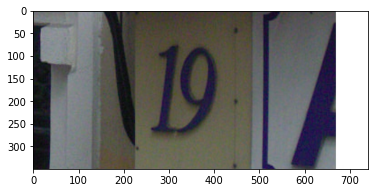

In [9]:
# display an image

img = 'RawData/train/1.png'
image = mpimg.imread(img)
plt.imshow(image)
plt.show()

In [10]:
# define a function for displaying the images with bounding boxes

def show_bboxes(img, file, bboxes, idx):
    data = get_image_boxes(file, bboxes, idx)
    fig, ax = plt.subplots()
    image = mpimg.imread(img) 
    for i in range(len(data['top'])):   
        ax.add_patch(Rectangle((data['left'][i], data['top'][i]), data['width'][i], data['height'][i],
                           linewidth=1, edgecolor='b', facecolor='none'))
    image = ax.imshow(image)
    plt.show()
    return image

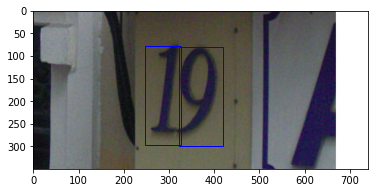

In [11]:
img = 'RawData/train/1.png'

show_bboxes(img, train, train_bbox, 0)

In [12]:
# define a function to merge the bounding boxes

def merge_boxes(file, bboxes, idx):
    data = get_image_boxes(file, bboxes, idx)
    left = min(data['left'])
    top = min(data['top'])
    width = max(map(add, data['left'], data['width'])) - left
    height = max(map(add, data['top'], data['height'])) - top
    # changes the zeros from label 10 to label 0
    labels = [x if x != 10 else 0 for x in data['label']]
    b_box = {'left': left, 'top': top, 'width': width, 'height': height, 'labels': labels}
    return b_box

Merging the bounding boxes will allow the model to view the number as one digit versus attempting to recognize multiple digits in one image.

In [13]:
merge_boxes(train, train_bbox, 0)

{'left': 246, 'top': 77, 'width': 173, 'height': 223, 'labels': [1, 9]}

In [14]:
# define a function to create a dictionary from all the image labels and bounding boxes

def merge_to_dict(file, bboxes, labels):
    data = {}
    num = file['digitStruct/name'].shape[0]
    for idx in range(num):
        b_box = merge_boxes(file, bboxes, idx)
        fname = get_image_label(file, labels, idx)
        data[fname] = b_box
    return data

In [15]:
train_data = merge_to_dict(train, train_bbox, train_labels)
test_data = merge_to_dict(test, test_bbox, test_labels)

In [59]:
# assign variables to the data for ease of working through the functions

path = os.getcwd()
train_path = os.path.join(path, 'RawData/train')
train_metafile = os.path.join(train_path, 'digitStruct.mat')
train_file = h5py.File(train_metafile, 'r')
test_path = os.path.join(path, 'RawData/test')
test_metafile = os.path.join(test_path, 'digitStruct.mat')
test_file = h5py.File(test_metafile, 'r')

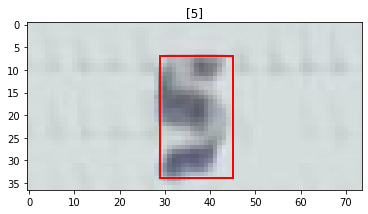

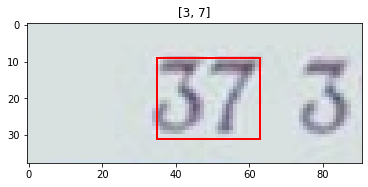

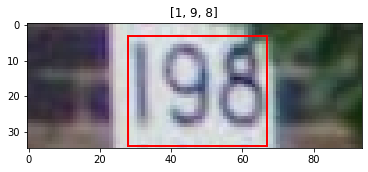

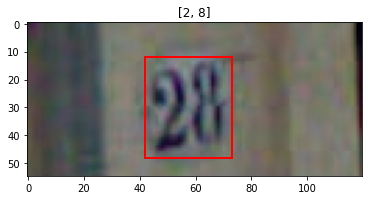

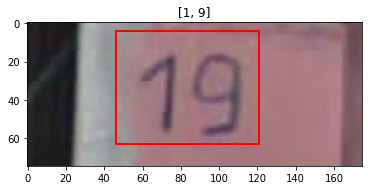

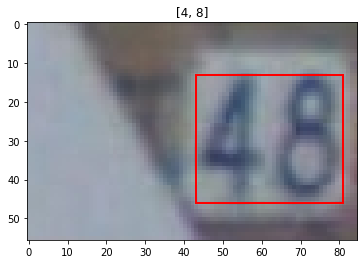

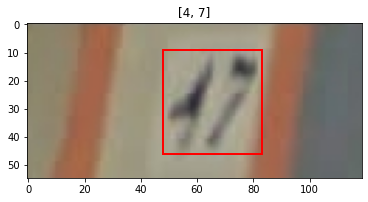

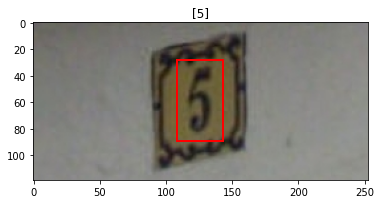

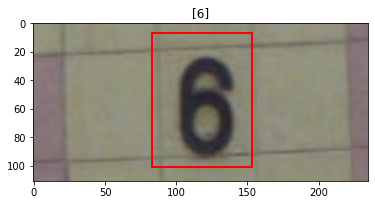

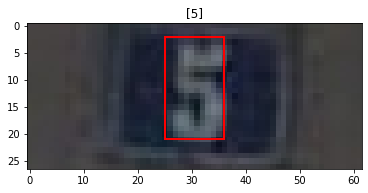

In [60]:
# display a few images to ensure everything works properly

file = train
bboxes = train_bbox

for _ in range(10):
    idx = random.randint(1, len(train_data))
    fn = '{}{}'.format(idx, '.png')
    x = train_data[fn]['left']
    y = train_data[fn]['top']
    w = train_data[fn]['width']
    h = train_data[fn]['height']
    img_f = os.path.join(train_path, fn)
    img = mpimg.imread(img_f)
    fig, ax = plt.subplots(1)
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.imshow(img)
    plt.title(train_data[fn]['labels'])
    plt.show()

## Crop and process the image data and convert it to csv

PNG
(155, 66)
RGB


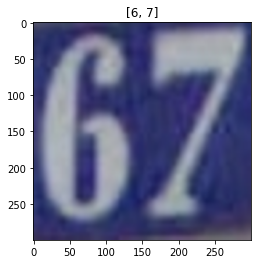

PNG
(178, 75)
RGB


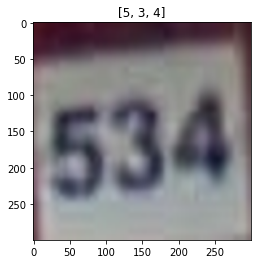

PNG
(69, 27)
RGB


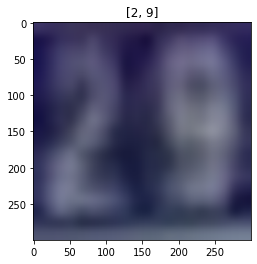

PNG
(77, 42)
RGB


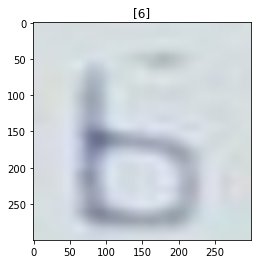

PNG
(216, 99)
RGB


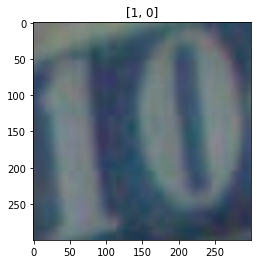

PNG
(113, 60)
RGB


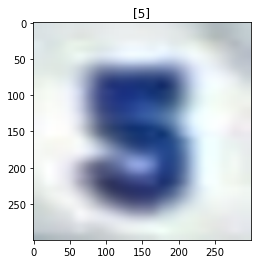

PNG
(235, 107)
RGB


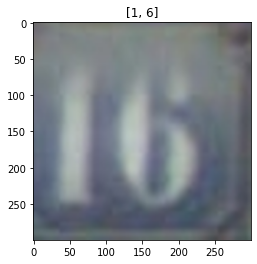

PNG
(99, 48)
RGB


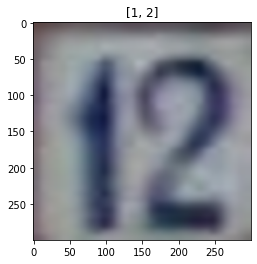

PNG
(122, 42)
RGB


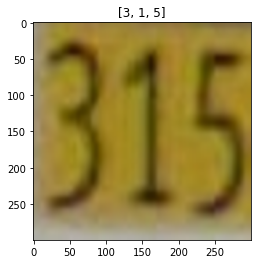

PNG
(68, 33)
RGB


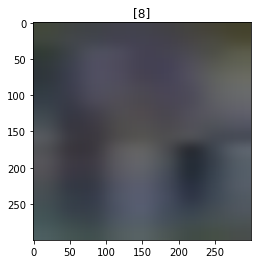

In [111]:
for _ in range(10):
    img_dict = train_data
    path = train_path
    idx = random.randint(1, len(train_data))
    fn = '{}{}'.format(idx, '.png')
    x = img_dict[fn]['left']
    y = img_dict[fn]['top']
    w = img_dict[fn]['width']
    h = img_dict[fn]['height']
    img_f = os.path.join(path, fn)
    img = Image.open(img_f)
    fig, ax = plt.subplots(1)
    img_crop = img.crop((x, y, (x+w), (y+h)))
    new_image = img_crop.resize((300,300))
    ax.imshow(new_image)
    plt.title(train_data[fn]['labels'])
    plt.show()

In [128]:
for _ in range(10):
    img_dict = train_data
    path = train_path
    idx = random.randint(1, len(train_data))
    fn = '{}{}'.format(idx, '.png')
    x = img_dict[fn]['left']
    y = img_dict[fn]['top']
    w = img_dict[fn]['width']
    h = img_dict[fn]['height']
    img_f = os.path.join(path, fn)
    img = Image.open(img_f)
    img_crop = img.crop((x, y, (x+w), (y+h)))
    new_image = img_crop.resize((32,32))
    img_array = np.asarray(new_image)
    img_list = np.ndarray.tolist(img_array.flatten())
    img_dict = {fn : img_list}
    print(img_dict)

{'25386.png': [44, 55, 99, 44, 56, 104, 45, 58, 111, 47, 62, 116, 49, 65, 122, 50, 66, 125, 48, 64, 124, 48, 63, 126, 48, 63, 129, 47, 62, 129, 36, 53, 121, 38, 55, 124, 47, 63, 132, 48, 63, 134, 35, 49, 121, 24, 38, 111, 31, 46, 120, 44, 61, 133, 53, 69, 141, 49, 63, 134, 45, 60, 130, 41, 57, 125, 37, 55, 121, 38, 56, 120, 41, 59, 123, 47, 65, 129, 56, 73, 135, 63, 79, 141, 66, 82, 144, 65, 81, 142, 61, 78, 142, 58, 76, 142, 43, 54, 98, 44, 56, 103, 46, 58, 110, 47, 62, 116, 49, 65, 121, 49, 67, 124, 48, 65, 125, 52, 68, 131, 54, 71, 135, 53, 70, 136, 41, 58, 125, 37, 54, 122, 39, 56, 124, 39, 55, 125, 31, 46, 118, 25, 40, 112, 32, 50, 121, 45, 63, 134, 53, 70, 141, 46, 62, 133, 39, 54, 125, 34, 51, 120, 35, 54, 120, 40, 59, 123, 44, 62, 126, 45, 63, 127, 45, 62, 126, 46, 63, 126, 49, 65, 128, 54, 71, 134, 53, 71, 136, 50, 68, 135, 43, 54, 98, 44, 56, 103, 47, 59, 110, 49, 64, 117, 50, 67, 121, 51, 69, 125, 53, 72, 130, 60, 79, 139, 64, 83, 145, 63, 81, 144, 49, 69, 132, 39, 59, 123, 

In [119]:
# define function to crop the bounding boxes then resize the images to 32 x 32

def crop(img_dict, path):
    idx = 1
    while idx in range(1, len(img_dict)):
        fn = '{}{}'.format(idx, '.png')
        x = img_dict[fn]['left']
        y = img_dict[fn]['top']
        w = img_dict[fn]['width']
        h = img_dict[fn]['height']
        img_f = os.path.join(path, fn)
        img = Image.open(img_f)
        new_image = img.crop((x, y, (x+w), (y+h)))
        new_image = img_crop.resize((32, 32))
        idx+=1
    return (fn, new_image)

In [132]:
# define function to convert cropped image to dataframe

def img_to_df(img_dict, path):
    image_list = []
    idx = 0
    while idx in range(len(img_dict)):
        fn, img = crop(img_dict, path)
        img_array = np.asarray(img)
        img_list = np.ndarray.tolist(img_array.flatten())
        image_list.append({'filename': fn, idx : img_list[idx]})
        idx+=1
    return pd.DataFrame(img_dictionary)

In [ ]:
train_img_df = img_to_df(train_data, train_path)
test_img_df = img_to_df(test_data, test_path)

In [ ]:
train_img_df.head()

In [18]:
# define a function to convert the labels and bounding box dimensions to a dataframe

def dict_to_df(file, labels, bboxes):
    box_list = []
    data_length = length(file)
    idx = 0
    while idx in range(data_length):
        fn = get_image_label(file, labels, idx)
        bbox = merge_boxes(file, bboxes, idx)
        box_list.append({'filename': fn,
                          'label': bbox['labels'],
                          'width': bbox['width'],
                          'height': bbox['height'],
                          'top': bbox['top'],
                          'left': bbox['left']})
        idx+=1
    return pd.DataFrame(box_list)

In [19]:
train_df = dict_to_df(train, train_labels, train_bbox)
test_df = dict_to_df(test, test_labels, test_bbox)

In [20]:
train_df.head()

,filename,label,width,height,top,left
0,1.png,"[1, 9]",173,223,77,246
1,2.png,"[2, 3]",47,36,25,77
2,3.png,"[2, 5]",17,15,5,17
3,4.png,"[9, 3]",28,34,13,57
4,5.png,"[3, 1]",37,49,7,52


In [21]:
# define a function to find the number of digits in each image

def label_len(df):
    digitCount = []
    i=0
    while i in range(len(df)):
        digitCount.append(len(df.iloc[i,1]))
        i+=1
    return digitCount

In [22]:
# add a digit count column

train_df['digitCount'] = label_len(train_df)
test_df['digitCount'] = label_len(test_df)

In [81]:
train_df['digitCount'].value_counts(sort=False)

1     5137
2    18130
3     8691
4     1434
5        9
Name: digitCount, dtype: int64

The dataset only includes 1 image with 6 digits. Might as well drop that image.

In [24]:
# drop rows with more than 5 digits

train_df = train_df[train_df['digitCount']<6]
test_df = test_df[test_df['digitCount']<6]

In [ ]:
# concatenate the dataframes
# filename, label, image data



In [ ]:
# save the dataframes to csv

train_df.to_csv('RawData/csv/train_bboxes.csv', index=False)
test_df.to_csv('RawData/csv/test_bboxes.csv', index=False)